In [84]:
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools
from tqdm import tqdm
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree


In [85]:
reward_p = np.array(
    [
        [0, 0],
        [1, 5],
        [4, 2],
        [7, 8],
        [3, 6],
        [8, 3],
        [2, 9],
        [6, 7],
        [9, 1],
        [5, 4],
        [7, 2],
        [10, 5],
        [12, 4],
        [11, 7],
        [14, 9],
        [13, 3],
        [9, 6],
        [15, 8],
        [16, 2],
        [18, 5],
        [20, 3],
    ]
)

reward_value = np.array(
    [0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105]
)

# grid_size = 5
# spacing = 3

# reward_p = np.array([
#     [i * spacing, j * spacing] 
#     for i in range(grid_size) 
#     for j in range(grid_size)
# ])

# reward_value = np.array(
#     [0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 37, 52, 40, 28]
# )

print(reward_p.shape[0], reward_value.shape[0])

NUM_REWARDS = reward_p.shape[0]

POP_SIZE = 300
NUM_GEN = 200

CX_PROB = 0.9
MUT_PROB = 0.7
MUT_DECAY_RATE = NUM_GEN / 150
TOURNAMENT_SIZE = 3

MAX_DISTANCE_BETWEEN_AGENTS = 3
BUDGET = 80
PROXIMITY_GAIN = 0.1
elite_size = 5

dist_mx = cdist(reward_p, reward_p, metric="euclidean")
kdtree = KDTree(reward_p)


21 21


In [86]:
def get_last_valid_idx(path):
    total_distance = 0
    curr_reward = 0

    valid_idx = 0
    for i in range(len(path)):
        next_reward = path[i]
        total_distance += dist_mx[curr_reward, next_reward]
        if total_distance > BUDGET:
            break
        valid_idx = i
        curr_reward = next_reward
    return valid_idx

In [87]:
def minimize_distance(ind: list) -> float:
    total_distance = 0
    curr_reward = 0

    for next_reward in ind:
        total_distance += dist_mx[curr_reward, next_reward]
        curr_reward = next_reward

    return total_distance


def maximize_reward(ind: list) -> float:
    last_idx = get_last_valid_idx(ind)
    reward = 0

    for i in range(last_idx + 1):
        next_reward = ind[i]
        reward += reward_value[next_reward]
    return reward


def maximize_team_gain(ind: list) -> float:
    last_idx = get_last_valid_idx(ind)
    team_gain = 0

    for i in range(last_idx + 1):
        next_reward = ind[i]

        current_point = reward_p[next_reward]
        indices_within_radius = kdtree.query_radius([current_point], r=MAX_DISTANCE_BETWEEN_AGENTS)[0]
        team_gain += sum(reward_value[idx] for idx in indices_within_radius)*PROXIMITY_GAIN

    return team_gain


def evaluate(ind: list, gen: int) -> float:
    min_distance = minimize_distance(ind)
    max_reward = maximize_reward(ind)
    team_gain = maximize_team_gain(ind)

    return max_reward + team_gain, min_distance


def calculate_mutation_probability(generation: int, max_generations: int, initial_prob: float, decay_rate: float) -> float:
    return initial_prob * np.exp(-decay_rate * (generation / max_generations))


In [ ]:
def evolve(toolbox):
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()

    population = toolbox.population(n=POP_SIZE)
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind, 0)

    record = stats.compile(population)
    logbook.record(gen=0, **record)

    for gen in tqdm(range(NUM_GEN), desc='Progress'):
        elite = tools.selBest(population, elite_size)[0]
        offspring = []

        # Crossover
        parents = toolbox.select(population, len(population) - 1)
        parents = list(map(toolbox.clone, parents))
        for _ in range(len(parents) // 2):
            parent1, parent2 = random.sample(parents, 2)
            parent1, parent2 = toolbox.clone(parent1), toolbox.clone(parent2)

            if np.random.random() < CX_PROB:
                toolbox.mate(parent1, parent2)
                del parent1.fitness.values
                del parent2.fitness.values
            offspring.extend([parent1, parent2])
            
        # Mutation
        mutation_prob = calculate_mutation_probability(gen, NUM_GEN, MUT_PROB, MUT_DECAY_RATE)
        for individual in offspring:
            if np.random.random() < mutation_prob:
                toolbox.mutate(individual)
                del individual.fitness.values

        # Fitness evaluation
        for ind in offspring:
            ind.fitness.values = toolbox.evaluate(ind, gen)

        # Elitism
        offspring.append(elite)
        population[:] = offspring

        record = stats.compile(population)
        logbook.record(gen=0, **record)

    return tools.selBest(population, 1)[0], logbook

In [89]:
def create_first_toolbox():
    creator.create("FitnessMulti", base.Fitness, weights=(1.0, -10.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti)

    toolbox = base.Toolbox()

    toolbox.register("genes", random.sample, range(NUM_REWARDS), NUM_REWARDS)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.genes)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxPartialyMatched)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=MUT_PROB)
    toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
    toolbox.register("evaluate", evaluate)
    return toolbox


In [90]:
individual, logbook = evolve(create_first_toolbox())

C:\Users\dti Digital\AppData\Roaming\Python\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\dti Digital\AppData\Roaming\Python\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
Progress: 100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


In [91]:
print(logbook)
print(maximize_reward(individual))
print(minimize_distance(individual))

avg    	gen	max   	min    	std    
412.706	0  	1078  	120.642	265.49 
435.16 	0  	1078  	117.359	285.383
434.755	0  	1200.5	109.135	291.771
430.501	0  	1200.5	114.378	284.981
430.295	0  	1200.5	119.139	285.672
429.854	0  	1200.5	118.296	286.917
437.432	0  	1200.5	120.719	293.038
433.83 	0  	1200.5	130.385	289.238
438.141	0  	1200.5	124.996	292.903
435.011	0  	1200.5	117.16 	292.453
431.925	0  	1200.5	124.423	286.581
425.726	0  	1200.5	129.866	282.696
433.327	0  	1200.5	119.801	290.008
439.784	0  	1200.5	123.504	295.808
433.481	0  	1200.5	121.5  	286.186
438.041	0  	1200.5	120.987	293.962
433.956	0  	1200.5	115.578	286.466
440.387	0  	1200.5	115.391	294.709
433.174	0  	1200.5	114.48 	289.352
432.123	0  	1200.5	115.943	289.872
441.916	0  	1200.5	123.504	294.522
435.959	0  	1200.5	123.504	292.298
434.026	0  	1200.5	114.573	290.724
450.516	0  	1220  	112.626	306.272
436.492	0  	1220  	124.635	291.608
437.262	0  	1220  	124.138	294.982
443.274	0  	1220  	116.289	303.997
444.93 	0  	1220  	1

(0.0, 24.25)

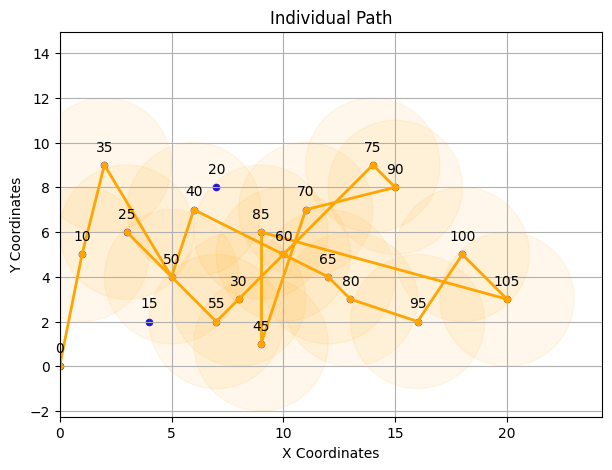

In [92]:
def plot_rewards(ax, reward_p: np.ndarray, reward_value: np.ndarray):
    ax.scatter(reward_p[:, 0], reward_p[:, 1], c='b', s=20, label='Rewards')
    for i, (x, y) in enumerate(reward_p):
        ax.annotate(reward_value[i], (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
    
    ax.set_xlabel("X Coordinates")
    ax.set_ylabel("Y Coordinates")


def plot_path(ax, reward_p: np.ndarray, individual: list, show_radius=False, show_path=True, color='orange'):
    total_distance = 0
    curr_reward = 0
    
    for next_reward in individual:
        if total_distance + dist_mx[curr_reward, next_reward] > BUDGET:
            break
        start = reward_p[curr_reward]
        end = reward_p[next_reward]
        if show_path:
            ax.plot([start[0], end[0]], [start[1], end[1]], linewidth=2, color=color, marker='o', markersize=4)

        if show_radius:
            circle = plt.Circle((end[0], end[1]), MAX_DISTANCE_BETWEEN_AGENTS, color=color, alpha=0.08)
            ax.add_patch(circle)
        
        total_distance += dist_mx[curr_reward, next_reward]
        curr_reward = next_reward

fig, ax = plt.subplots(figsize=(7, 5))

plot_rewards(ax, reward_p, reward_value)
plot_path(ax, reward_p, individual, True)

ax.set_title("Individual Path")
plt.grid(True)
plt.axis('equal')
plt.ylim(0, None)
plt.xlim(0, None)

In [93]:
virtual_path = []
dist = 0
cp = 0
for p in individual:
    if dist + dist_mx[cp, p] > BUDGET:
        break
    dist += dist_mx[cp, p]
    virtual_path.append(p)
    cp = p
virtual_path = np.array(virtual_path)
virtual_path

array([ 1,  6,  9,  7, 11, 12, 15, 18, 19, 20, 16,  8, 13, 17, 14,  5, 10,
        4])

In [94]:
print(virtual_path[np.argsort(reward_value[virtual_path])])
np.argsort(reward_value[virtual_path])

[ 1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


array([ 0, 17, 15,  1,  3, 11,  2, 16,  4,  5, 12, 14,  6, 10, 13,  7,  8,
        9])

In [95]:
def get_valid_points(p: int) -> list:
    current_point = reward_p[p]
    indices_within_radius = kdtree.query_radius([current_point], r=MAX_DISTANCE_BETWEEN_AGENTS)[0]
    return indices_within_radius

clusters = [
    get_valid_points(p) for p in virtual_path
]
valid_points = np.unique(np.concatenate(clusters))
valid_points

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

### Second Phase

In [96]:
mapping = {point: idx for idx, point in enumerate(valid_points)}
clusters = [np.array([mapping[point] for point in cluster]) for cluster in clusters]
clusters, mapping

([array([0, 3]),
  array([5]),
  array([1, 3, 8, 9]),
  array([2, 6]),
  array([ 4, 10, 11, 12, 15]),
  array([10, 11, 14]),
  array([11, 14]),
  array([17]),
  array([18, 19]),
  array([18, 19]),
  array([ 2, 10, 12, 15]),
  array([4, 7, 9]),
  array([10, 12, 15]),
  array([13, 16]),
  array([13, 16]),
  array([ 4,  7,  9, 10]),
  array([1, 4, 7, 8, 9]),
  array([0, 3, 8])],
 {np.int64(1): 0,
  np.int64(2): 1,
  np.int64(3): 2,
  np.int64(4): 3,
  np.int64(5): 4,
  np.int64(6): 5,
  np.int64(7): 6,
  np.int64(8): 7,
  np.int64(9): 8,
  np.int64(10): 9,
  np.int64(11): 10,
  np.int64(12): 11,
  np.int64(13): 12,
  np.int64(14): 13,
  np.int64(15): 14,
  np.int64(16): 15,
  np.int64(17): 16,
  np.int64(18): 17,
  np.int64(19): 18,
  np.int64(20): 19})

In [97]:
def init_individual(icls) -> list:
    perm1 = []
    perm2 = []

    visited_points = set()

    for cluster_points in clusters:
        unique_points = [p for p in cluster_points if p not in visited_points]

        if unique_points:
            shuffled_points1 = np.random.permutation(unique_points)
            shuffled_points2 = np.random.permutation(unique_points)

            perm1.extend(shuffled_points1)
            perm2.extend(shuffled_points2)

            visited_points.update(unique_points)

    genes = np.array([perm1, perm2])

    num_columns = genes.shape[1]
    shuffled_indices = np.random.permutation(num_columns)

    genes = genes[:, shuffled_indices]

    return icls(genes)

In [98]:
def mut_individual(individual: list, indpb: float) -> tuple:
    path1, path2 = individual
    tools.mutShuffleIndexes(path1, indpb=indpb)
    tools.mutShuffleIndexes(path2, indpb=indpb)
    return (individual,)

In [99]:
def cx_partialy_matched(ind1: np.ndarray, ind2: np.ndarray) -> tuple:
    size = ind1.shape[1]
    
    cxpoint1, cxpoint2 = sorted(random.sample(range(size), 2))
    
    for row in range(ind1.shape[0]):
        p1, p2 = np.zeros(size, dtype=int), np.zeros(size, dtype=int)
        
        for i in range(size):
            p1[ind1[row][i]] = i
            p2[ind2[row][i]] = i

        for i in range(cxpoint1, cxpoint2):
            temp1 = ind1[row, i]
            temp2 = ind2[row, i]

            ind1[row, i], ind2[row, i] = temp2, temp1
            
            ind1[row, p1[temp2]] = temp1
            ind2[row, p2[temp1]] = temp2

            p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
            p2[temp1], p2[temp2] = p2[temp2], p2[temp1]

    return ind1, ind2

def cx_individual(ind1: list, ind2: list) -> tuple:
    tools.cxPartialyMatched(ind1[0], ind2[0])
    tools.cxPartialyMatched(ind1[1], ind2[1])
    return ind1, ind2

In [100]:
def second_phase_maximize_reward(ind: list) -> float:
    visited = set()
    fitness = 0

    for path in ind:
        last_idx = get_last_valid_idx(path)

        for i in range(last_idx + 1):
            next_reward = path[i]

            if not next_reward in visited:
                fitness += reward_value[next_reward]
                visited.add(next_reward)

    return fitness

def second_phase_minimize_distance(ind: list) -> float:
    total_distance = 0
    for path in ind:
        curr_reward = 0
        for next_reward in path:
            total_distance += dist_mx[curr_reward, next_reward]
            curr_reward = next_reward

    return total_distance

def minimize_distance_between_agents(ind: list) -> float:
    last_idx1 = get_last_valid_idx(ind[0])
    last_idx2 = get_last_valid_idx(ind[1])
    min_last_idx = min(last_idx1, last_idx2)

    full_distance = 0

    for p1, p2 in zip(ind[0][:min_last_idx], ind[1][:min_last_idx]):
        full_distance += dist_mx[p1, p2]

    if last_idx1 > last_idx2:
        for p1 in ind[0][min_last_idx:last_idx1]:
            full_distance += dist_mx[p1, p2]
    elif last_idx2 > last_idx1:
        for p2 in ind[1][min_last_idx:last_idx2]:
            full_distance += dist_mx[p1, p2]

    return full_distance

def penalize_distance(ind: list) -> float:
    last_idx1 = get_last_valid_idx(ind[0])
    last_idx2 = get_last_valid_idx(ind[1])
    min_last_idx = min(last_idx1, last_idx2)

    for p1, p2 in zip(ind[0][:min_last_idx+1], ind[1][:min_last_idx+1]):
        if dist_mx[p1, p2] > MAX_DISTANCE_BETWEEN_AGENTS:
            return True

    if last_idx1 > last_idx2:
        for p1 in ind[0][min_last_idx+1:last_idx1]:
            if dist_mx[p1, ind[1][min_last_idx - 1]] > MAX_DISTANCE_BETWEEN_AGENTS:
                return True
    elif last_idx2 > last_idx1:
        for p2 in ind[1][min_last_idx+1:last_idx2]:
            if dist_mx[ind[0][min_last_idx - 1], p2] > MAX_DISTANCE_BETWEEN_AGENTS:
                return True

    return False


def second_phase_evaluate(ind: list, gen: int) -> float:
    mapped_ind = []
    for path in ind:
        mapped_path = [valid_points[point] for point in path]
        mapped_ind.append(mapped_path)

    max_reward = second_phase_maximize_reward(mapped_ind)
    min_distance = second_phase_minimize_distance(mapped_ind)
    min_distance_between_agents = minimize_distance_between_agents(mapped_ind)

    penalize_dist = penalize_distance(mapped_ind)

    if penalize_dist and gen > NUM_GEN // 2:
        return (-1000, min_distance + 5000, min_distance_between_agents + 5000)
    elif penalize_dist:
        reward_penalty = 500 * (1 + gen / NUM_GEN)
        distance_penalty = 1000 * (1 + gen / NUM_GEN)
        return (max_reward - reward_penalty, min_distance + distance_penalty, min_distance_between_agents + distance_penalty)

    return (max_reward, min_distance, min_distance_between_agents)

In [105]:
POP_SIZE = 400
NUM_GEN = 2000

CX_PROB = 0.8
MUT_PROB = 0.5
TOURNAMENT_SIZE = 4

MAX_DISTANCE_BETWEEN_AGENTS = 3.5
BUDGET = 80
elite_size = 5

In [106]:
def create_second_toolbox():
    creator.create("FitnessMulti", base.Fitness, weights=(2.0, -20.0, -10.0))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMulti)

    toolbox = base.Toolbox()

    toolbox.register("individual", init_individual, creator.Individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", cx_individual)
    toolbox.register("mutate", mut_individual, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
    toolbox.register("evaluate", second_phase_evaluate)
    return toolbox

In [107]:
def plot_distances(path1, path2):
    last_idx = min(get_last_valid_idx(path1), get_last_valid_idx(path2))
    fig, ax = plt.subplots(figsize=(10, 5))
    dist = []
    for p1, p2 in zip(path1[:last_idx+1], path2[:last_idx+1]):
        dist.append(dist_mx[p1, p2])
    ax.plot(range(len(dist)), dist, color='red', marker='o')
    ax.set_ylabel("Distance between agents")
    ax.set_title("Distance between agents in the two paths. Max distance allowed: 3.5")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Progress: 100%|██████████| 2000/2000 [01:53<00:00, 17.68it/s]


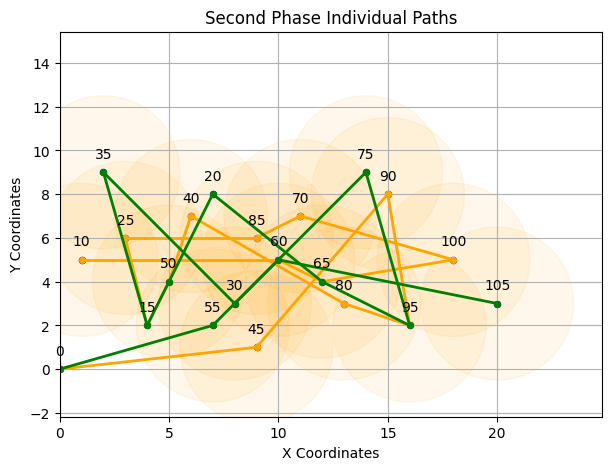

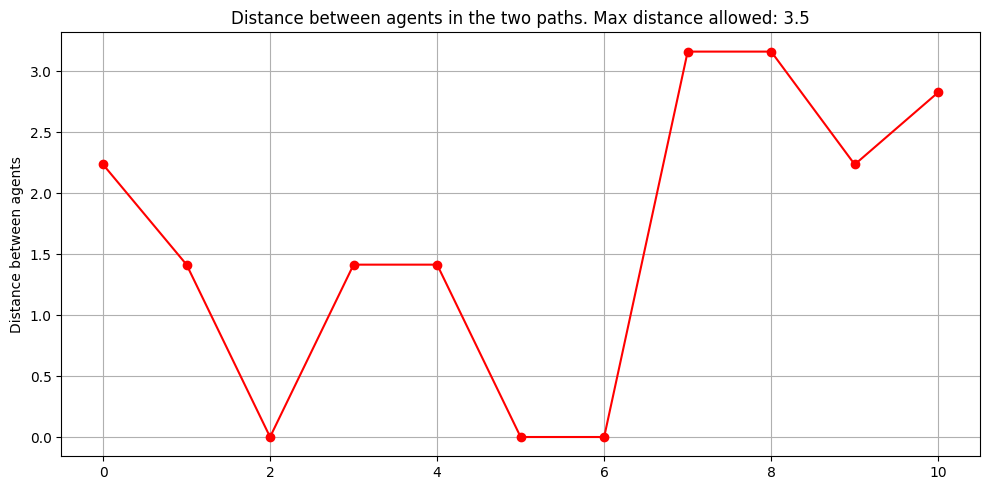

In [108]:
second_phase_individual, second_phase_logbook = evolve(create_second_toolbox())
mapped_second_phase_individual = [np.array([valid_points[p] for p in perm]) for perm in second_phase_individual]

fig, ax = plt.subplots(figsize=(7, 5))

plot_rewards(ax, reward_p, reward_value)
plot_path(ax, reward_p, individual, show_path=False, show_radius=True)
plot_path(ax, reward_p, mapped_second_phase_individual[0], color='orange')
plot_path(ax, reward_p, mapped_second_phase_individual[1], color='green')

ax.set_title("Second Phase Individual Paths")
plt.grid(True)
plt.axis('equal')
plt.ylim(0, None)
plt.xlim(0, None)
plt.show()
plot_distances(mapped_second_phase_individual[0], mapped_second_phase_individual[1])